# Requirements

In [43]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **count of page loads**. Your task involves employing bagging and boosting methods to forecast the **count of page loads**. To accomplish this, you will use data from the preceding three days, consisting of **count of page loads**, **count of unique visits**, **count of first time-visits**, **count of returning visits**, and the current **day**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Website Visitors Dataset

## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [27]:
df = pd.read_csv('../data/website-visitors.csv', index_col='date')

In [28]:
df.head(7)

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
date,,,,,
9/14/2014,Sunday,2.146,1.582,1.430,152.0
9/15/2014,Monday,3.621,2.528,2.297,231.0
9/16/2014,Tuesday,3.698,2.630,2.352,278.0
9/17/2014,Wednesday,3.667,2.614,2.327,287.0
9/18/2014,Thursday,3.316,2.366,2.130,236.0
9/19/2014,Friday,2.815,1.863,1.622,241.0
9/20/2014,Saturday,1.658,1.118,985.000,133.0


Explore the dataset using visualizations of your choice.

In [29]:
# sns.pairplot(df)
# plt.show()

Encode the categorical features.

In [30]:
encoder = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
df['day_of_week'] = df['day_of_week'].map(encoder)

# Feauture Extraction
Apply a lag of one, two, and three days to each chosen feature (except `day_of_week`), creating a set of features representing the statistics from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [31]:
for col in ['page_loads', 'unique_visits', 'first_time_visits', 'returning_visits']:
    for i in range(1, 3 + 1):
        df[f'{col}_lag_{i}'] = df[col].shift(i)

In [32]:
df.dropna(inplace=True)

In [33]:
df.head(3)

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits,page_loads_lag_1,page_loads_lag_2,page_loads_lag_3,unique_visits_lag_1,unique_visits_lag_2,unique_visits_lag_3,first_time_visits_lag_1,first_time_visits_lag_2,first_time_visits_lag_3,returning_visits_lag_1,returning_visits_lag_2,returning_visits_lag_3
date,,,,,,,,,,,,,,,,,
9/17/2014,2,3.667,2.614,2.327,287.0,3.698,3.621,2.146,2.630,2.528,1.582,2.352,2.297,1.430,278.0,231.0,152.0
9/18/2014,3,3.316,2.366,2.130,236.0,3.667,3.698,3.621,2.614,2.630,2.528,2.327,2.352,2.297,287.0,278.0,231.0
9/19/2014,4,2.815,1.863,1.622,241.0,3.316,3.667,3.698,2.366,2.614,2.630,2.130,2.327,2.352,236.0,287.0,278.0


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [34]:
X, y = df.drop('page_loads', axis=1), df['page_loads']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [40]:
model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

Use the trained model to make predictions for the test set.

In [41]:
y_pred = model.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [42]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MAE: 0.225319468822171
MSE: 0.07915274379792155
R2: 0.9436446114848653


### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [44]:
xgmodel = XGBRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

Use the trained model to make predictions for the test set.

In [45]:
y_pred_xg = xgmodel.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [46]:
print(f'MAE: {mean_absolute_error(y_test, y_pred_xg)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_xg)}')
print(f'R2: {r2_score(y_test, y_pred_xg)}')

MAE: 0.18877169994063517
MSE: 0.05830774976554548
R2: 0.9584858877429483


# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the number of estimators (`n_estimators`) for the XGBoost model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `n_estimators` and evaluating the model's performance using cross-validation. Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Fine-tuning the XGBoost Hyperparameter
Experiment with various values for `n_estimators` and evaluate the model's performance using cross-validation.

In [50]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
}

In [51]:
cv = TimeSeriesSplit(n_splits=5)

In [52]:
grid = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    params, 
    cv=cv, 
    scoring='r2', 
    n_jobs=-1
)

In [53]:
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400, 500]},
             scoring='r2')

In [56]:
print(grid.best_params_)

{'n_estimators': 200}


In [61]:
grid_df = pd.DataFrame(grid.cv_results_)
grid_df.set_index('rank_test_score', inplace=True)
grid_df.sort_index(inplace=True)

In [64]:
grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,
1,3.420903,1.806991,0.034809,0.006186,200,{'n_estimators': 200},0.979930,0.962721,0.981137,0.953181,0.979209,0.971236,0.011275
2,5.777297,2.852108,0.047476,0.002626,300,{'n_estimators': 300},0.979878,0.962152,0.981101,0.953356,0.979385,0.971174,0.011319
3,1.611855,0.746286,0.017155,0.000977,100,{'n_estimators': 100},0.979522,0.962085,0.982266,0.953016,0.978844,0.971147,0.011523
4,7.573161,3.605153,0.068620,0.011570,400,{'n_estimators': 400},0.980011,0.961209,0.980778,0.953223,0.979462,0.970937,0.011492
5,8.811418,4.027334,0.072607,0.006297,500,{'n_estimators': 500},0.979838,0.961116,0.980890,0.953188,0.979553,0.970917,0.011524


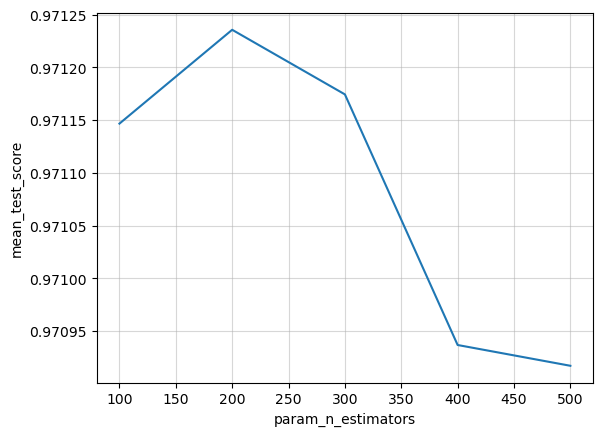

In [67]:
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=grid_df)

plt.grid(True, alpha=0.5)
plt.show()

## Final Assessment of the Model Performance
Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

In [54]:
y_pred_grid = grid.predict(X_test)

In [55]:
print(f'MAE: {mean_absolute_error(y_test, y_pred_grid)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_grid)}')
print(f'R2: {r2_score(y_test, y_pred_grid)}')

MAE: 0.22604372979214762
MSE: 0.07977549164474577
R2: 0.9432012257578419
